<a href="https://colab.research.google.com/github/wfwiggins/RSNA-NLP-2020/blob/master/RSNA20_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSNA 2020**
## **Hands-on AI for Non-Coders:** Basics of Information Extraction from Radiology Reports


In [ ]:
#@title **System Setup:** After installation of the necessary libraries, the system will restart. This _WILL_ generate an error message, which is expected 😉

# Installing dependencies
import os
from IPython.display import clear_output

!pip install fastai --upgrade >/dev/null
!pip install xmltodict >/dev/null

clear_output()
os.kill(os.getpid(), 9)

In [ ]:
#@title **Downloading the Data:** This step will download a subset of the [NLM Open-i "Indiana University Chest X-ray Reports" dataset](https://openi.nlm.nih.gov/faq#collection).

!curl https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz | tar xvz >/dev/null


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1086k  100 1086k    0     0  2786k      0 --:--:-- --:--:-- --:--:-- 2786k


In [ ]:
#@title **Preprocessing steps:** The reports come in XML format. In this cell, we parse the XML data and extract the "Findings" and "Impression" from each report, then extract labels of "normal" or "abnormal" from the metadata included in the XML file.

import glob
import xmltodict
from fastai.basics import *

def xml_parse(f):
    with open(f) as xml:
        report_dict = xmltodict.parse(xml.read())
    xml.close()
    return report_dict

def get_label(report):
    label = L(report['eCitation']['MeSH']['major'])
    return 'normal' if label[0].lower() == 'normal' else 'abnormal'

def get_text(report):
    text_dict = {}
    text = report['eCitation']['MedlineCitation']['Article']['Abstract']['AbstractText']
    findings = text[2]
    text_dict['findings'] = findings['#text'] if '#text' in findings else ''
    impression = text[3]
    text_dict['impression'] = impression['#text'] if '#text' in impression else ''
    return text_dict

def process_report(report):
    label = get_label(report)
    report_dict = get_text(report)
    report_dict['label'] = label
    return report_dict

fps = L(glob.glob('/content/ecgen-radiology/*'))
reports = fps.map(xml_parse)
reports_df = pd.DataFrame(reports.map(process_report))
reports_df

,findings,impression,label
0,,No comparison chest x-XXXX. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.,normal
1,"The heart is normal size. The mediastinum is unremarkable. There is no pleural effusion, pneumothorax, or focal airspace disease. The XXXX are unremarkable.",No acute cardiopulmonary abnormality.,normal
2,"No pneumothorax, pleural effusion or airspace consolidation. Stable right lower lung granuloma. Interval to right clavicle XXXX procedure. Heart size and pulmonary vasculature appear within normal limits. XXXX XXXX are intact.",No acute cardiopulmonary abnormality. .,abnormal
3,The lungs and pleural spaces show no acute abnormality. Heart size and pulmonary vascularity within normal limits. .,1. No acute pulmonary abnormality.,normal
4,"The heart is normal in size and contour. There is no mediastinal widening. The lungs are clear bilaterally. No large pleural effusion or pneumothorax. Mild dextro curvature of the thoracic spine, possibly positional.",No acute cardiopulmonary abnormalities.,abnormal
...,...,...,...
3950,Stable cardiomegaly. The lungs are clear. Stable left lung base calcifications. No focal consolidations. No pneumothorax or pleural effusions. The XXXX are intact.,No acute cardiopulmonary abnormalities. Stable cardiomegaly.,abnormal
3951,No focal consolidation. No visualized pneumothorax. No large pleural effusions. The heart size and cardiomediastinal silhouette is grossly unremarkable. There is motion artifact on the lateral radiograph.,1. No acute cardiopulmonary findings.,abnormal
3952,Cardiac and mediastinal contours are within normal limits. The lungs are clear. Bony structures are intact.,Negative chest x-XXXX.,normal
3953,Cardiac silhouette within normal limits. Central pulmonary vasculature is not engorged. No pneumothorax or pleural effusion. Visualized osseous structures are unremarkable. No edema or focal consolidation in the lungs.,No evidence of acute cardiopulmonary process.,normal


# Exploring the data

As you'll see in the table above, there are some reports where the "Impression" states something along the lines of "No acute cardiopulmonary abnormality" but the label is "abnormal". This is usually due to a chronic incidental finding or artifact that is mentioned in the "Findings", but isn't included in the "Impression".

This point is important to remember when we think about which text we want to use to train our classifier.

# of Abnormal: 2564
# of Normal: 1391



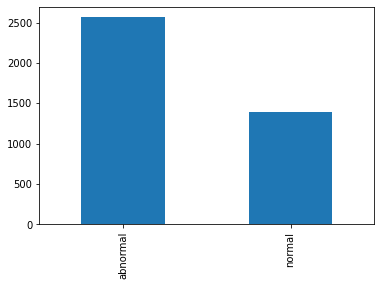

In [ ]:
#@title Let's take a look at the relative balance between normal and abnormal reports in our dataset.
label_counts = reports_df.label.value_counts()
print('# of Abnormal:', label_counts['abnormal'])
print('# of Normal:', label_counts['normal'])
print()
label_counts.plot.bar(x='Label', y='# of Reports');